In [46]:
### library import
import cv2
import lime
import os
import pandas as pd
import numpy as np
import keras
import random
import seaborn as sns
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from lime import lime_image
from keras import backend as K
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import imagenet_utils

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [47]:
### creating data frame
healthy_dirs = [
    r'/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL',
    r'/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL',
    r'/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL',
]

pneumonia_dir = [ 
    r'/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA',
    r'/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA',
    r'/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA'
]

filepaths = []
labels = []
dict_lists = [healthy_dirs, pneumonia_dir]
class_labels = ['Normal', 'Pneumonia']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
pneumonia_data = pd.concat([Fseries, Lseries], axis=1)
pneumonia_df = pd.DataFrame(pneumonia_data)
print(pneumonia_df.head())
print(pneumonia_df["labels"].value_counts())

                                           filepaths  labels
0  /kaggle/input/chest-xray-pneumonia/chest_xray/...  Normal
1  /kaggle/input/chest-xray-pneumonia/chest_xray/...  Normal
2  /kaggle/input/chest-xray-pneumonia/chest_xray/...  Normal
3  /kaggle/input/chest-xray-pneumonia/chest_xray/...  Normal
4  /kaggle/input/chest-xray-pneumonia/chest_xray/...  Normal
labels
Pneumonia    4273
Normal       1583
Name: count, dtype: int64


In [48]:
pneumonia_df.shape

(5856, 2)

In [49]:
#### training 70% testing 20% validation 10%
train_images, test_images = train_test_split(pneumonia_df, test_size=0.3, random_state=42,stratify=pneumonia_df["labels"])
train_set, val_set = train_test_split(pneumonia_df, test_size=0.2, random_state=42, stratify=pneumonia_df["labels"])

In [50]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(4684, 2)
(1757, 2)
(1172, 2)
(4099, 2)


In [51]:
##image preprocessing

image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(224,224),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=32,
                                      shuffle=False
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(224,224),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 4684 validated image filenames belonging to 2 classes.
Found 1757 validated image filenames belonging to 2 classes.
Found 1172 validated image filenames belonging to 2 classes.


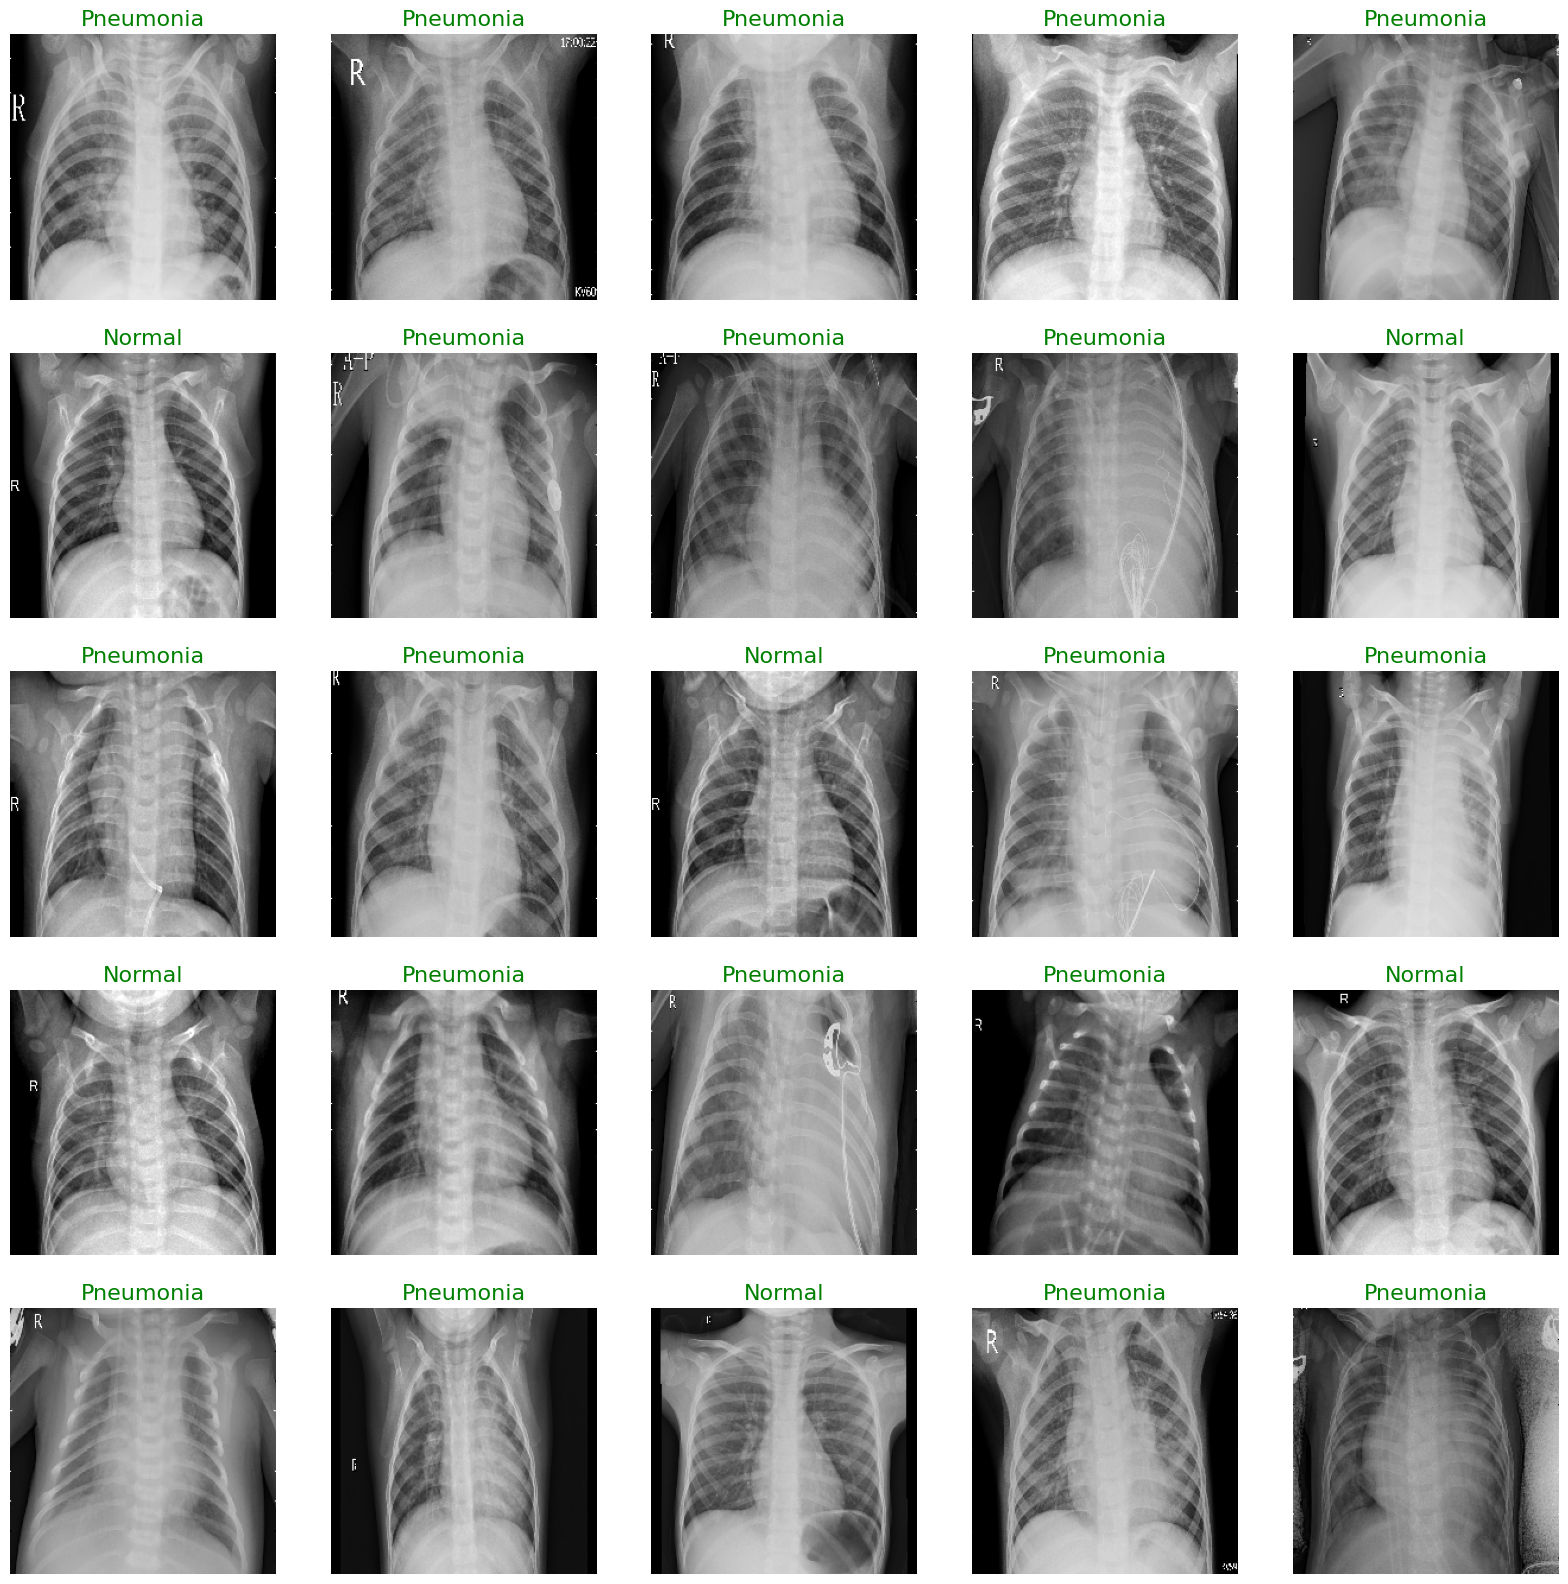

In [52]:
###image show
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
    
show_knee_images(train)

In [53]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(2, 2), strides=(2, 2), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 112, 112, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 56, 56, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 18, 18, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 9, 9, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 9, 9, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 4, 4, 512)      │         2,04

 Total params: 11,488,322 (43.82 MB)

 Trainable params: 11,483,010 (43.80 MB)

 Non-trainable params: 5,312 (20.75 KB)

In [54]:
history = model.fit(train, epochs=30, validation_data=val, verbose=1)

Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 63s 358ms/step - accuracy: 0.6663 - loss: 1.3844 - val_accuracy: 0.7295 - val_loss: 0.6314
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 47s 308ms/step - accuracy: 0.7837 - loss: 0.5652 - val_accuracy: 0.7295 - val_loss: 1.6070
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 48s 311ms/step - accuracy: 0.8325 - loss: 0.4087 - val_accuracy: 0.7295 - val_loss: 1.4875
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 48s 314ms/step - accuracy: 0.8421 - loss: 0.3579 - val_accuracy: 0.8464 - val_loss: 0.3470
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 47s 306ms/step - accuracy: 0.8477 - loss: 0.3760 - val_accuracy: 0.9352 - val_loss: 0.1837
Epoch 6/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 47s 304ms/step - accuracy: 0.8794 - loss: 0.2961 - val_accuracy: 0.9505 - val_loss: 0.1740
Epoch 7/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 48s 312ms/step - accuracy: 0.8901 - loss: 0.2645 - val_accuracy: 0.9326 - val_loss: 0.1688
Epoch 8/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 48s 313ms/step - accuracy: 0.8864 - loss: 0

In [55]:
# history = model.fit(train, epochs=10, validation_data=val, verbose=1)

In [56]:
model.evaluate(test, verbose=1)

55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 291ms/step - accuracy: 0.9754 - loss: 0.0694


[0.08276790380477905, 0.9721115827560425]

In [57]:
model.save("pneumonia_Model.h5")


In [58]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 267ms/step


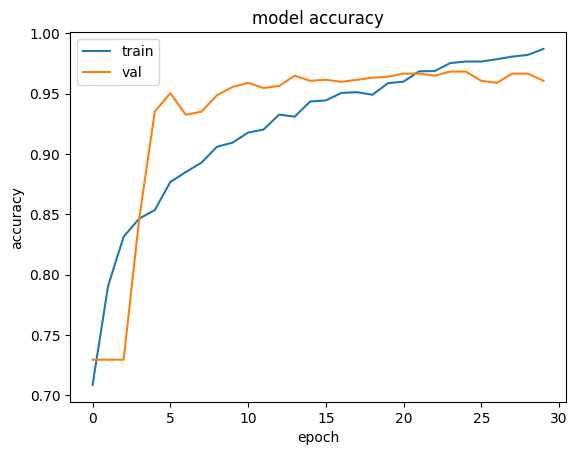

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

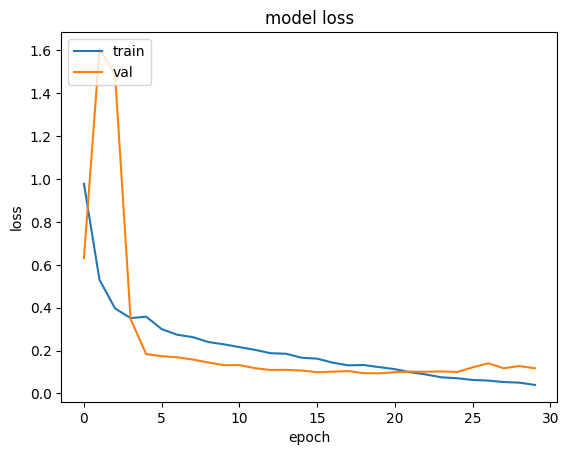

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [61]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

      Normal       0.93      0.96      0.95       475
   Pneumonia       0.99      0.98      0.98      1282

    accuracy                           0.97      1757
   macro avg       0.96      0.97      0.96      1757
weighted avg       0.97      0.97      0.97      1757

Accuracy of the Model: 97.2%


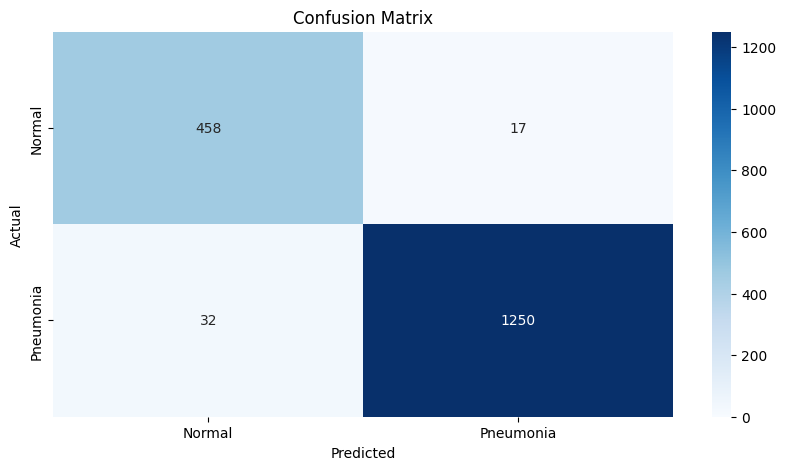

In [62]:
class_labels = ['Normal', 'Pneumonia']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

In [41]:
y_scores=model.predict(test)

55/55 ━━━━━━━━━━━━━━━━━━━━ 15s 268ms/step


In [43]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
y_encoded = label_encoder.fit_transform(y_test)

In [44]:
# # Use the probabilities for the positive class (class 1)
y_prob = y_scores[:, 1]

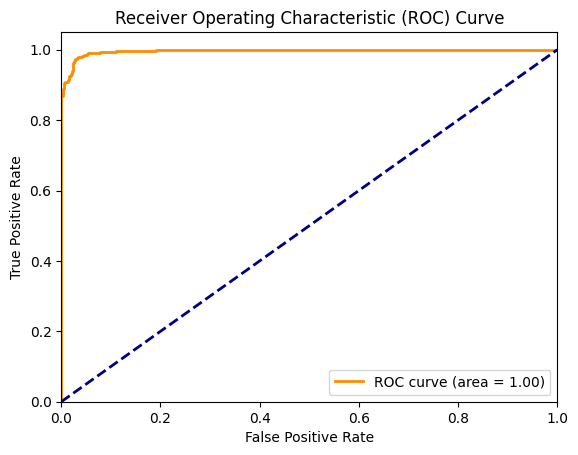

In [48]:
# Compute ROC curve and ROC area
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


fpr, tpr, thresholds = roc_curve(y_encoded, y_prob)
roc_auc = roc_auc_score(y_encoded, y_prob)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()